# Example: Feature engineering
------------------------------

This example shows how to use automated feature generation to improve a model's performance.

The data used is a variation on the [Australian weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) from Kaggle. You can download it from [here](https://github.com/tvdboom/ATOM/blob/master/examples/datasets/weatherAUS.csv). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look
X.head()

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  MelbourneAirport     18.0     26.9      21.4          7.0       8.9   
1          Adelaide     17.2     23.4       0.0          NaN       NaN   
2            Cairns     18.6     24.6       7.4          3.0       6.1   
3          Portland     13.6     16.8       4.2          1.2       0.0   
4           Walpole     16.4     19.9       0.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity9am  \
0         SSE           41.0          W        SSE  ...         95.0   
1           S           41.0          S        WSW  ...         59.0   
2         SSE           54.0        SSE         SE  ...         78.0   
3         ESE           39.0        ESE        ESE  ...         76.0   
4          SE           44.0         SE         SE  ...         78.0   

   Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0         54.0       1019.5       1017.0       8.0       5.0     18.5   
1         36.0       1015.7       1015.7       NaN       NaN     17.7   
2         57.0       1018.7       1016.6       3.0       3.0     20.8   
3         74.0       1021.4       1020.5       7.0       8.0     15.6   
4         70.0       1019.4       1018.9       NaN       NaN     17.4   

   Temp3pm  RainToday  RainTomorrow  
0     26.0        Yes             0  
1     21.9         No             0  
2     24.1        Yes             0  
3     16.0        Yes             1  
4     18.1         No             0  

[5 rows x 22 columns]

## Run the pipeline

In [3]:
# Initialize atom and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0)
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)
atom.encode(max_onehot=10, infrequent_to_value=0.04)

In [4]:
atom.verbose = 2  # Increase verbosity to see the output

# Let's see how a LightGBM model performs
atom.run('LGB', metric='auc')


Training ========================= >>
Models: LGB
Metric: auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> auc: 0.9847
Test evaluation --> auc: 0.8597
Time elapsed: 1.232s
-------------------------------------------------
Time: 1.232s


Final results ==================== >>
Total time: 1.237s
-------------------------------------
LightGBM --> auc: 0.8597


## Deep Feature Synthesis

In [5]:
# Since we are going to compare different datasets,
# we need to create separate branches
atom.branch = "dfs"

Successfully created new branch: dfs.


In [6]:
# Create 50 new features using dfs
atom.feature_generation("dfs", n_features=50, operators=["add", "sub", "log"])

Fitting FeatureGenerator...
Generating new features...
 --> 50 new features were added.


In [7]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the nans attribute
atom.nans

Location                        0
MinTemp                         0
MaxTemp                         0
Rainfall                        0
Evaporation                     0
                               ..
Temp9am - WindSpeed9am          0
WindDir3pm + WindDir9am         0
WindDir3pm - WindGustSpeed      0
WindGustSpeed - WindSpeed9am    0
RainTomorrow                    0
Length: 74, dtype: int64

In [8]:
# Turn off warnings in the future
atom.warnings = False

# Impute the data again to get rid of the missing values
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)

Fitting Imputer...
Imputing missing values...
 --> Imputing 6310 missing values using the knn imputer in column NATURAL_LOGARITHM(Rainfall).
 --> Imputing 7 missing values using the knn imputer in column NATURAL_LOGARITHM(Temp3pm).


In [9]:
# 50 new features may be to much...
# Let's check for multicollinearity and use rfecv to reduce the number
atom.feature_selection(
    strategy="rfecv",
    solver="LGB",
    n_features=30,
    scoring="auc",
    max_correlation=0.98,
)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature MinTemp - WindDir9am was removed due to collinearity with another feature.
 --> Feature MaxTemp was removed due to collinearity with another feature.
 --> Feature Temp3pm was removed due to collinearity with another feature.
 --> Feature MaxTemp + Temp3pm was removed due to collinearity with another feature.
 --> Feature Evaporation - WindDir9am was removed due to collinearity with another feature.
 --> Feature Sunshine was removed due to collinearity with another feature.
 --> Feature Sunshine - WindDir3pm was removed due to collinearity with another feature.
 --> Feature WindGustDir was removed due to collinearity with another feature.
 --> Feature WindGustSpeed was removed due to collinearity with another feature.
 --> Feature Location + WindSpeed9am was removed due to collinearity with another feature.
 --> Feature WindSpeed3pm was removed due to collinearity with another feature.
 --> Feature Humidity9am was 

In [10]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear_

drop  \
0           MinTemp - WindDir9am   
1                        MaxTemp   
2                        Temp3pm   
3              MaxTemp + Temp3pm   
4       Evaporation - WindDir9am   
5                       Sunshine   
6          Sunshine - WindDir3pm   
7                    WindGustDir   
8                  WindGustSpeed   
9        Location + WindSpeed9am   
10                  WindSpeed3pm   
11                   Humidity9am   
12        Humidity9am + Location   
13                   Humidity3pm   
14                   Pressure9am   
15    Pressure9am + RainToday_No   
16      Pressure9am - WindDir9am   
17                   Pressure3pm   
18     Pressure3pm + Pressure9am   
19    Pressure3pm + RainToday_No   
20                      Cloud9am   
21         Cloud9am - WindDir3pm   
22                      Cloud3pm   
23         Temp9am - WindGustDir   
24                  RainToday_No   
25  RainToday_No - RainToday_Yes   
26     RainToday_No - WindDir3pm   
27    RainToday_Yes - WindDir9am   
28      Location - RainToday_Yes   

                                         corr_feature  \
0                                             MinTemp   
1    Temp3pm, MaxTemp + Temp3pm, MaxTemp + WindDir9am   
2    MaxTemp, MaxTemp + Temp3pm, MaxTemp + WindDir9am   
3              MaxTemp, Temp3pm, MaxTemp + WindDir9am   
4                                         Evaporation   
5       Sunshine + WindGustDir, Sunshine - WindDir3pm   
6                    Sunshine, Sunshine + WindGustDir   
7                              Location + WindGustDir   
8                RainToday_infrequent + WindGustSpeed   
9                                        WindSpeed9am   
10                            Location + WindSpeed3pm   
11     Cloud3pm + Humidity9am, Humidity9am + Location   
12                Humidity9am, Cloud3pm + Humidity9am   
13                          Evaporation + Humidity3pm   
14  Pressure3pm + Pressure9am, Pressure9am + RainT...   
15  Pressure9am, Pressure3pm + Pressure9am, Pressu...   
16  Pressure9am, Pressure3pm + Pressure9am, Pressu...   
17  Pressure3pm + Pressure9am, Pressure3pm + RainT...   
18  Pressure9am, Pressure3pm, Pressure3pm + RainTo...   
19  Pressure3pm, Pressure3pm + Pressure9am, Pressu...   
20      Cloud9am + WindGustDir, Cloud9am - WindDir3pm   
21                   Cloud9am, Cloud9am + WindGustDir   
22                             Cloud3pm + WindGustDir   
23                                            Temp9am   
24  RainToday_No + WindDir9am, RainToday_No - Rain...   
25  RainToday_No, Location - RainToday_Yes, RainTo...   
26  RainToday_No, RainToday_No + WindDir9am, RainT...   
27                                      RainToday_Yes   
28                       RainToday_No - RainToday_Yes   

                                        corr_value  
0                                              1.0  
1                              0.9826, 0.9958, 1.0  
2                           0.9826, 0.9955, 0.9824  
3                           0.9958, 0.9955, 0.9957  
4                                           0.9999  
5                                   0.9999, 0.9999  
6                                   0.9999, 0.9998  
7                                              1.0  
8                                              1.0  
9                                              1.0  
10                                             1.0  
11                                     0.9941, 1.0  
12                                     1.0, 0.9941  
13                                           0.984  
14                             0.9907, 0.9983, 1.0  
15                          0.9983, 0.9868, 0.9983  
16                             1.0, 0.9906, 0.9983  
17                             0.9904, 0.9982, 1.0  
18  0.9907, 0.9904, 0.9912, 0.9903, 0.9868, 0.9906  
19                          0.9982, 0.9912, 0.9981  
20                                  0.9999, 0.9999  
21                                  0.9999, 0.9996  
22               

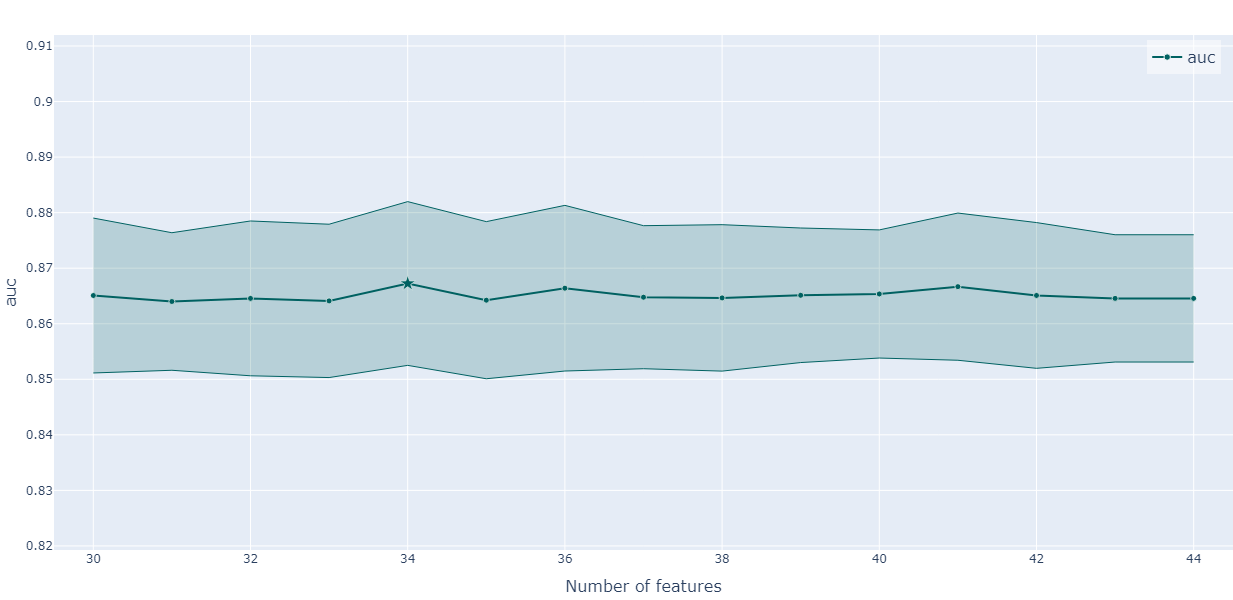

In [11]:
# After applying rfecv, we can plot the score per number of features
atom.plot_rfecv()

In [12]:
# Let's see how the model performs now
# Add a tag to the model's acronym to not overwrite previous LGB
atom.run("LGB_dfs", errors="raise")


Training ========================= >>
Models: LGB_dfs
Metric: auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> auc: 0.9913
Test evaluation --> auc: 0.8569
Time elapsed: 1.421s
-------------------------------------------------
Time: 1.421s


Final results ==================== >>
Total time: 1.426s
-------------------------------------
LightGBM --> auc: 0.8569


## Genetic Feature Generation

In [13]:
# Create another branch for the genetic features
# Split form master to avoid the dfs features
atom.branch = "gfg_from_main"

Successfully created new branch: gfg.


In [14]:
# Create new features using Genetic Programming
atom.feature_generation(strategy='gfg', n_features=20)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.05         0.137033        3         0.469867              N/A     24.01s
   1     3.10          0.36817        5           0.5039              N/A     28.27s
   2     3.45          0.43587        7         0.523106              N/A     24.16s
   3     4.82         0.476183        9         0.529742              N/A     19.71s
   4     6.34         0.499341       13         0.542883              N/A     17.45s
   5     6.99         0.502678       13         0.545525              N/A     17.25s
   6     8.53         0.509234       13         0.547516              N/A     16.68s
   7     8.76         0.513208       13         0.547516              N/A     16.00s
   8     9.08         0.514045       15        

In [15]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features_

name                                        description   fitness
0   x23  mul(Cloud3pm, mul(sub(sub(add(WindGustSpeed, H...  0.536434
1   x24  mul(mul(Cloud3pm, sub(sub(add(WindGustSpeed, H...  0.536434
2   x25  mul(Cloud3pm, mul(sub(sub(add(Humidity3pm, Win...  0.536434
3   x26  mul(mul(Cloud3pm, sub(sub(add(Humidity3pm, Win...  0.536434
4   x27  mul(mul(Cloud3pm, sub(sub(sub(add(WindGustSpee...  0.536161
5   x28  mul(Cloud3pm, mul(sub(sub(sub(add(WindGustSpee...  0.536161
6   x29  mul(Cloud3pm, mul(sub(sub(sub(add(Humidity3pm,...  0.536161
7   x30  mul(Cloud3pm, mul(sub(sub(sub(sub(add(WindGust...  0.535103
8   x31  mul(Cloud3pm, mul(sub(sub(sub(sub(add(Humidity...  0.535103
9   x32  mul(mul(Cloud3pm, sub(sub(sub(sub(add(WindGust...  0.535103
10  x33  mul(mul(Cloud3pm, sub(sub(sub(sub(add(Humidity...  0.535103
11  x34  mul(Cloud3pm, mul(sub(sub(add(WindGustSpeed, H...  0.534696
12  x35  mul(Cloud3pm, mul(sub(sub(add(WindGustSpeed, s...  0.532632
13  x36  mul(Cloud3pm, mul(sub(sub(add(WindGustSpeed, s...  0.532188
14  x37  mul(mul(Cloud3pm, sub(sub(add(WindGustSpeed, s...  0.532188

In [16]:
# Fit the model again
atom.run("LGB_gfg", metric="auc")


Training ========================= >>
Models: LGB_gfg
Metric: auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> auc: 0.9867
Test evaluation --> auc: 0.8654
Time elapsed: 1.229s
-------------------------------------------------
Time: 1.229s


Final results ==================== >>
Total time: 1.234s
-------------------------------------
LightGBM --> auc: 0.8654


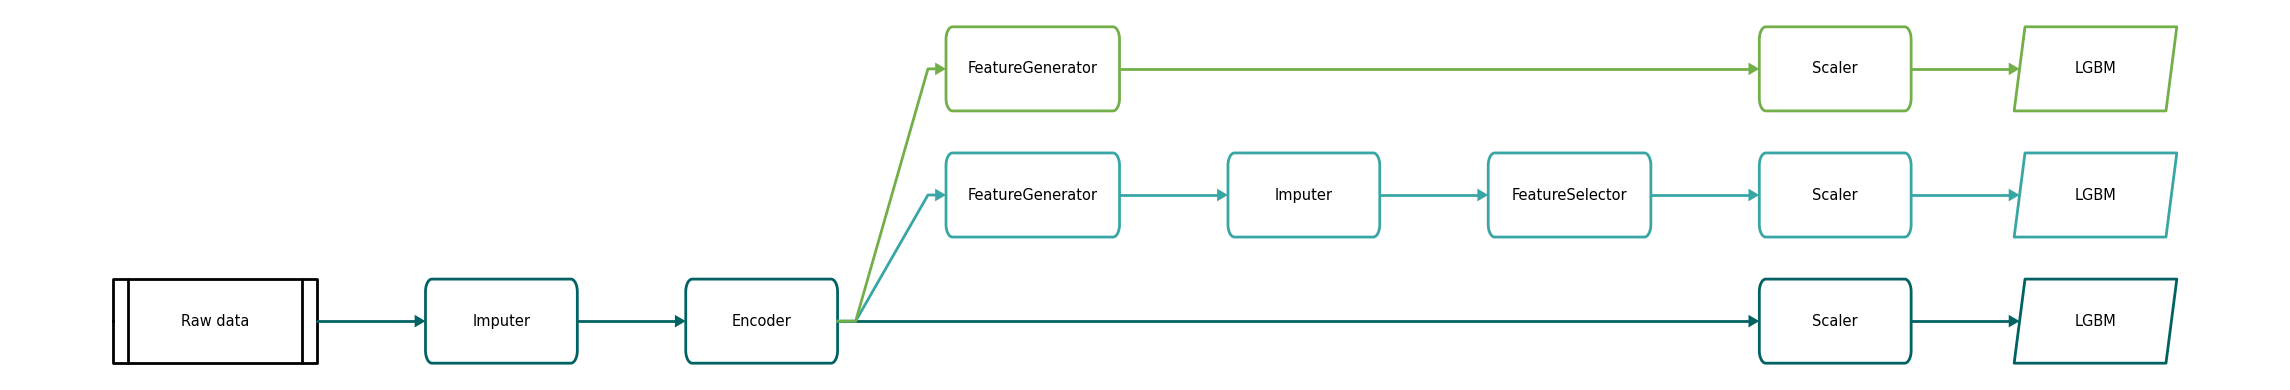

In [17]:
# Visualize the whole pipeline
atom.plot_pipeline()

## Analyze the results

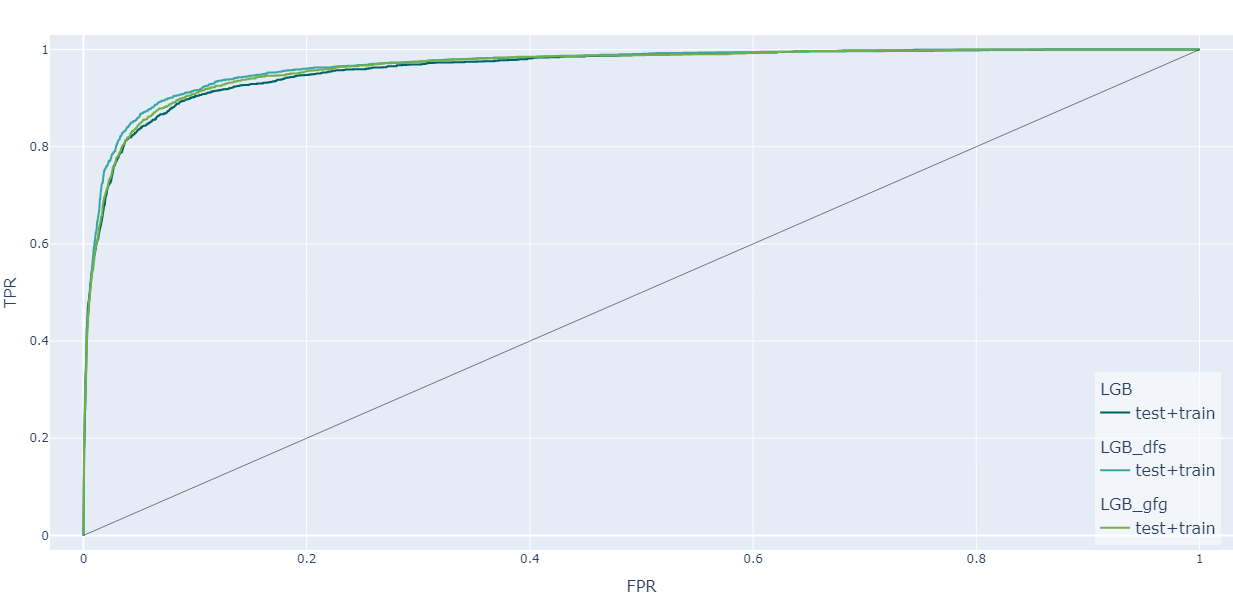

In [18]:
# Use atom's plots to compare the three models
atom.plot_roc(rows="test+train")

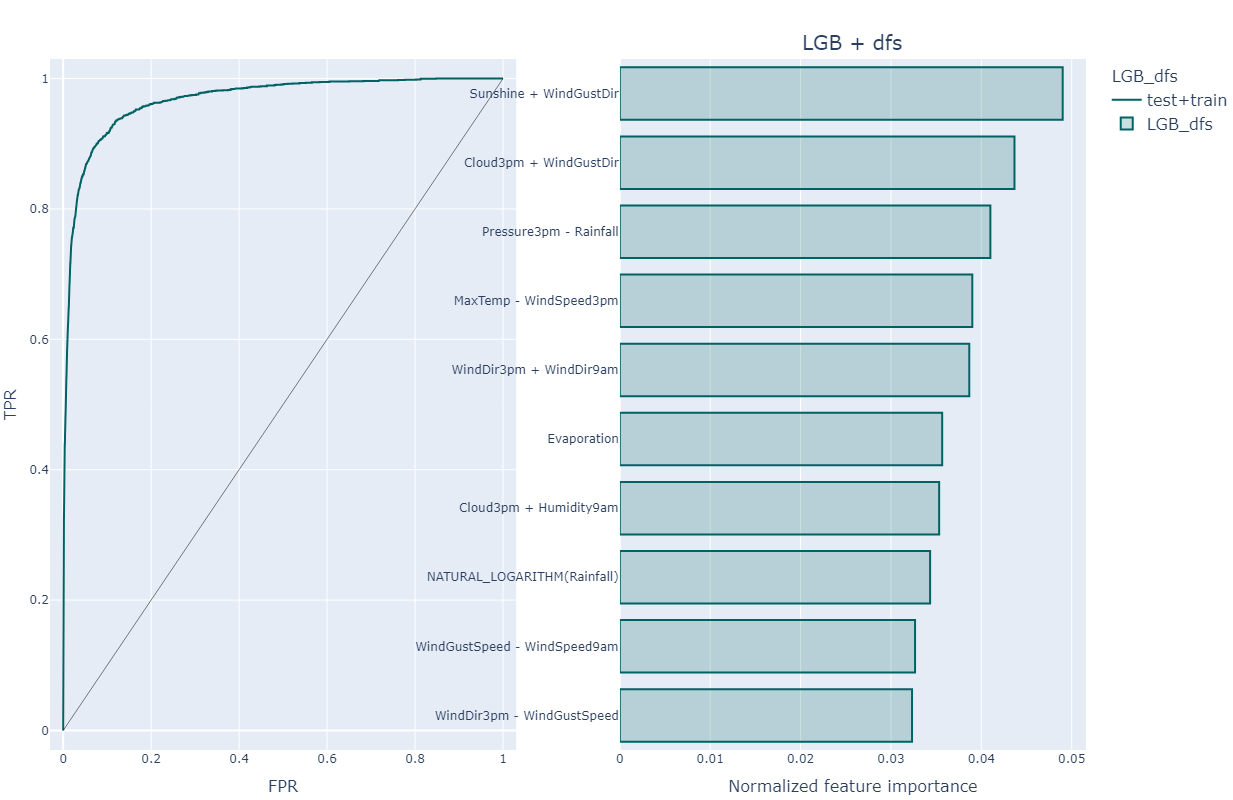

In [19]:
# To compare other plots it might be useful to use a canvas
with atom.canvas(1, 2, figsize=(1800, 800)):
    atom.lgb_dfs.plot_roc(rows="test+train")
    atom.lgb_dfs.plot_feature_importance(show=10, title="LGB + dfs")

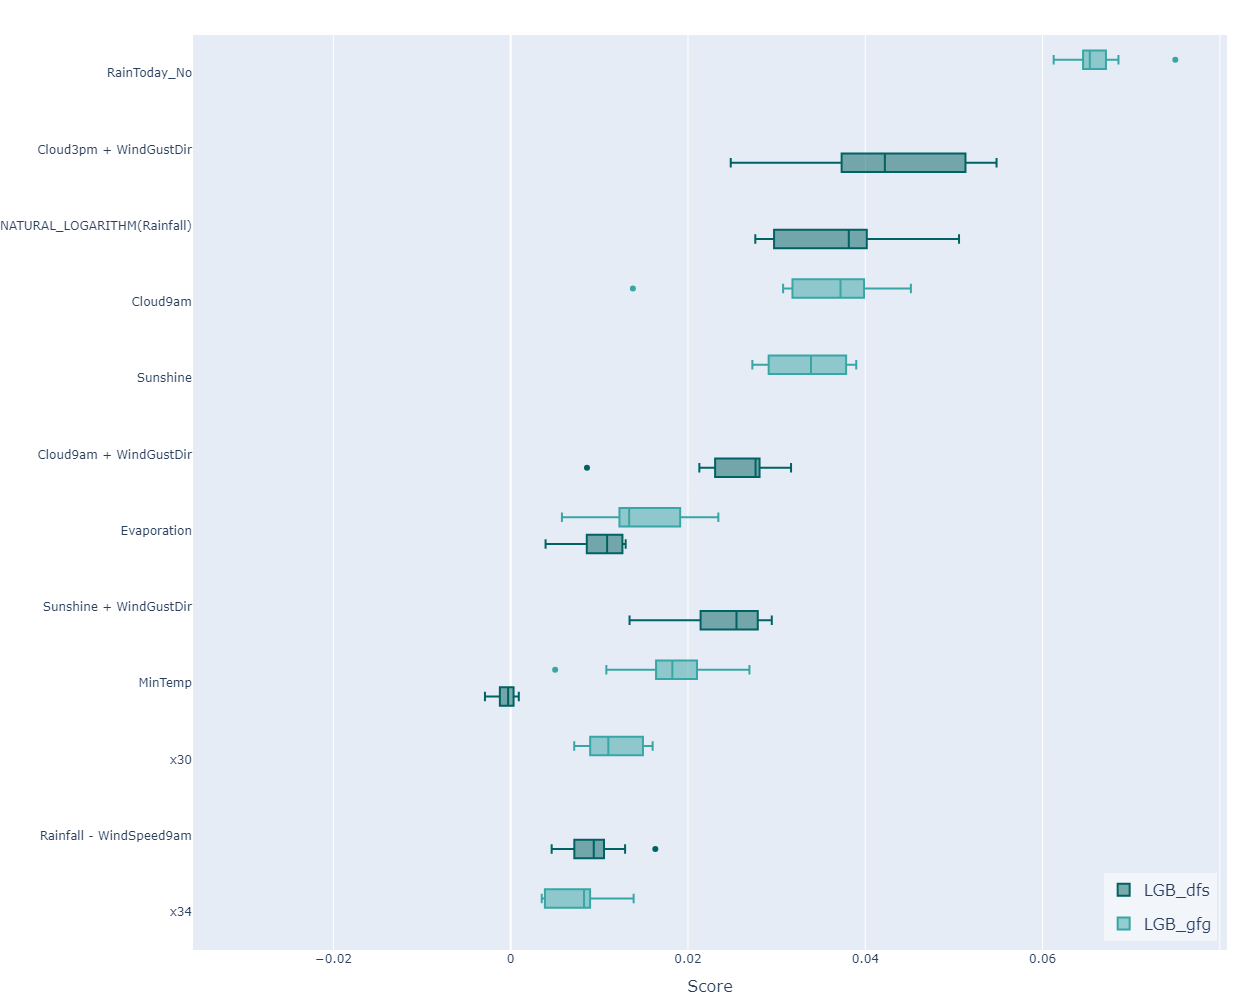

In [20]:
# We can check the feature importance with other plots as well
atom.plot_permutation_importance(models=["LGB_dfs", "LGB_gfg"], show=12)

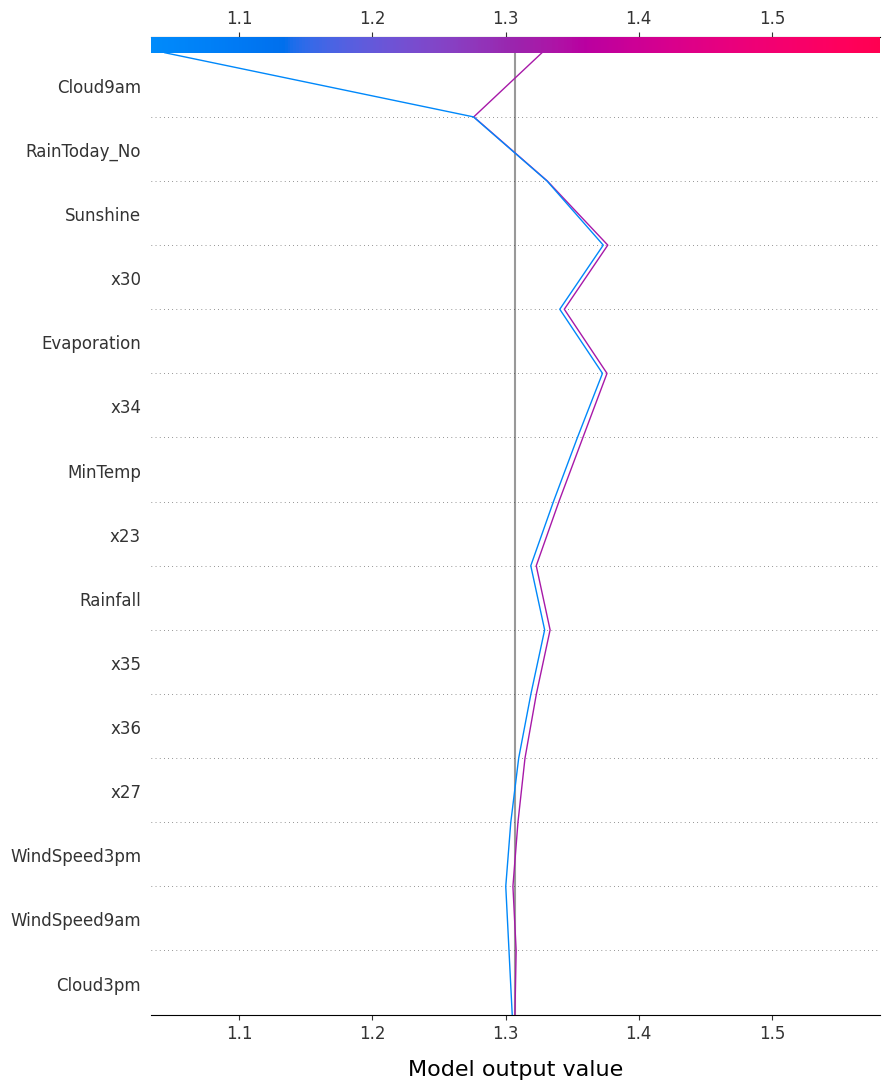

In [21]:
atom.LGB_gfg.plot_shap_decision(rows=(0, 10), show=15)